# Experiments with TSP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F

from general.utils import draw_graph

print(f"PyTorch version: {torch.__version__}")

import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Make MiniZinc work in Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

from problems.tsp.tsp_env_multibinary import TSPEnvironmentMultiBinary

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

TSP_DATA_DIR = os.path.join(BASE_PATH, "problems", "tsp", "data", "generated")

TSP_SOLVERS_DIR = os.path.join(BASE_PATH, "problems", "tsp", "minizinc")
TSP_INIT_SOLVER_PATH = os.path.join(TSP_SOLVERS_DIR, "tsp_init.mzn")
TSP_REPAIR_SOLVER_PATH = os.path.join(TSP_SOLVERS_DIR, "tsp_repair.mzn")

problems_paths = [path for path in os.listdir(TSP_DATA_DIR) if path.endswith(".json")]
print(len(problems_paths))

PyTorch version: 2.3.0
100


In [45]:
env = TSPEnvironmentMultiBinary(
    problem_instance_path=os.path.join(TSP_DATA_DIR, problems_paths[0]),
    init_model_path=TSP_INIT_SOLVER_PATH,
    repair_model_path=TSP_REPAIR_SOLVER_PATH,
    solver_name="gecode",
    max_episode_length=10
)

print("==== Observation Space ====")
print(env.observation_space)

print(env.observation_space.sample())

print("==== Action Space ====")
print(env.action_space)

print(env.action_space.sample(n=4))

obs, _ = env.reset()
print(obs)

==== Observation Space ====
Dict('problem': Dict('node_positions': Box(0, 1000, (20, 2), int32)), 'solution': Dict('route': Sequence(Discrete(20, start=1), stack=False)))
OrderedDict([('problem', OrderedDict([('node_positions', array([[372, 264],
       [131, 988],
       [960,  45],
       [672, 193],
       [701, 921],
       [ 84, 554],
       [532, 179],
       [575, 846],
       [425, 196],
       [983, 605],
       [257, 961],
       [632, 120],
       [722, 913],
       [ 37, 345],
       [662, 602],
       [916, 911],
       [351, 662],
       [403, 190],
       [482, 626],
       [481, 728]]))])), ('solution', OrderedDict([('route', (19, 5, 7, 14, 17, 13, 19, 17, 4, 9, 2, 3, 20, 14, 18, 20, 16, 9, 2, 9))]))])
==== Action Space ====
MultiBinary(20)
[1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
{'problem': {'node_positions': [{'x': 74, 'y': 528}, {'x': 658, 'y': 280}, {'x': 314, 'y': 534}, {'x': 160, 'y': 915}, {'x': 756, 'y': 153}, {'x': 841, 'y': 843}, {'x': 748, 'y': 954}, {'x': 

In [5]:
from itertools import combinations

list(combinations(range(20), 4))

4845

In [46]:
def preprocess(observation) -> Data:
    node_positions = observation['problem']['node_positions']
    node_features = torch.tensor([[node['x'], node['y']] for node in node_positions], dtype=torch.float)
    node_positions = node_features.clone()
    
    route = observation['solution']['route']
    edges = []
    for i in range(len(route) - 1):
        src = route[i] - 1
        dst = route[i + 1] - 1
        edges.append((src, dst))
        edges.append((dst, src))
    
    src = route[-1] - 1
    dst = route[0] - 1
    edges.append((src, dst))
    edges.append((dst, src))
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    edge_attr = torch.tensor([[1] for _ in edges], dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, pos=node_positions)
    
graph_data = preprocess(obs)
graph_data

Data(x=[20, 2], edge_index=[2, 40], edge_attr=[40, 1], pos=[20, 2])

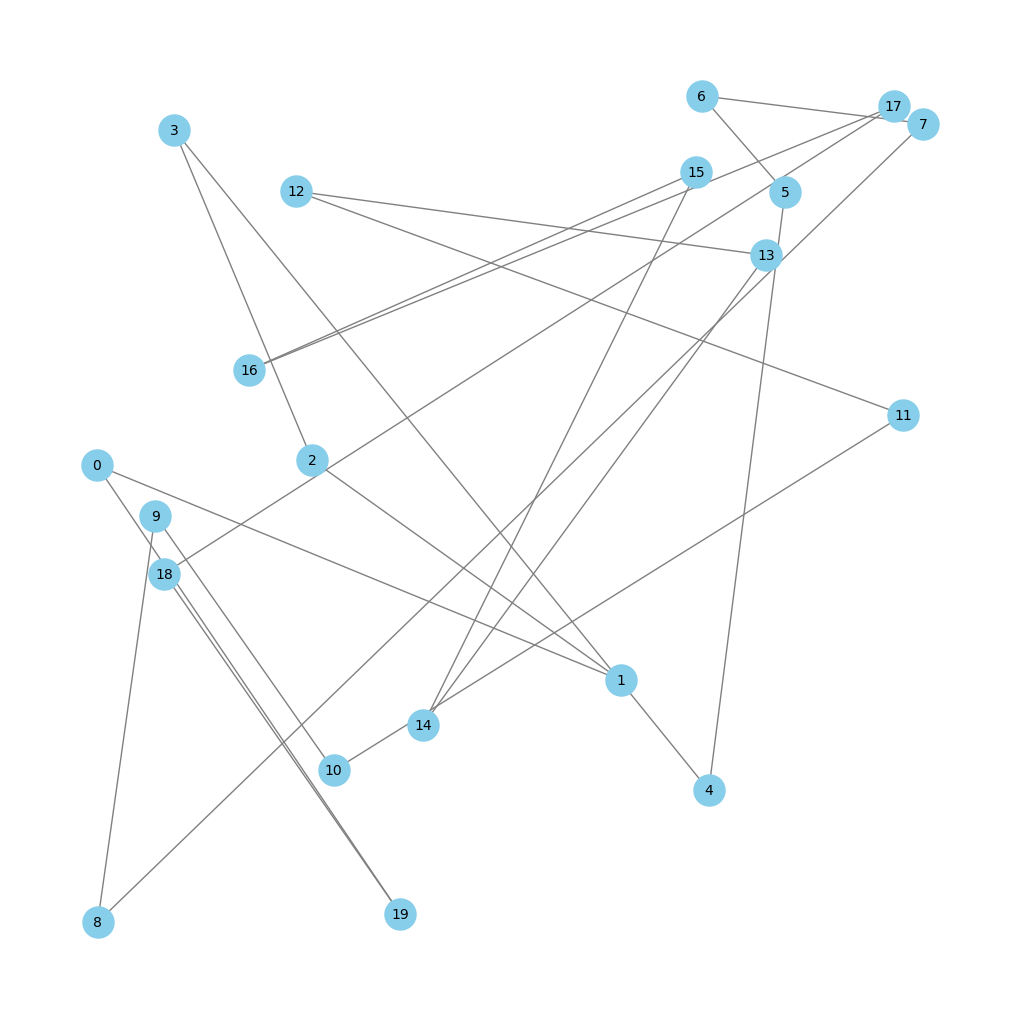

In [49]:
from general.utils import draw_graph

draw_graph(graph_data)

In [7]:
graph_data.is_undirected()

True

In [37]:
from torch_geometric.nn import GATConv

class GraphFeatureExtractor(torch.nn.Module):
    def __init__(
        self, 
        in_channels, 
        hidden_channels, 
        out_channels, 
        num_heads,
        edge_dim,
        output_features_dim
    ):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, concat=False, edge_dim=edge_dim)
        self.fc = nn.Linear(out_channels * 

    def forward(self, x, edge_index, edge_attr):
        print(x.shape)
        
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)
        
        print(x.shape)
        
        # x = torch.mean(x, dim=1)  # Aggregating channels
        x = torch.flatten(x)
        print(x.shape)
        
        x = self.fc(x)
        return F.sigmoid(x)

class GATDestroyOperator(nn.Module):
    def __init__(
        self, 
        in_channels, 
        hidden_channels, 
        out_channels, 
        num_heads,
        edge_dim,
        action_dim
    ):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, concat=False, edge_dim=edge_dim)
        self.fc = nn.Linear(out_channels * action_dim, action_dim)

    def forward(self, x, edge_index, edge_attr):
        print(x.shape)
        
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)
        
        print(x.shape)
        
        # x = torch.mean(x, dim=1)  # Aggregating channels
        x = torch.flatten(x)
        print(x.shape)
        
        x = self.fc(x)
        return F.sigmoid(x)

In [43]:
model = GATDestroyOperator(in_channels=2, hidden_channels=8, out_channels=2, num_heads=4, edge_dim=1, action_dim=20)

loader = DataLoader([graph_data], batch_size=1)
for data in loader:
    output = model(data.x, data.edge_index, data.edge_attr)
    print(output.size())
    print(output)

torch.Size([20, 2])
torch.Size([20, 2])
torch.Size([40])
torch.Size([20])
tensor([0.3498, 0.8176, 0.7226, 0.3217, 0.4049, 0.5295, 0.5081, 0.6106, 0.5457,
        0.7359, 0.5333, 0.3389, 0.5825, 0.4485, 0.6105, 0.4035, 0.6185, 0.4441,
        0.3418, 0.3631], grad_fn=<SigmoidBackward0>)


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

gamma = 0.99

# Training loop using REINFORCE
for episode in range(1):
    obs, _ = env.reset()
     
    graph_data = preprocess(obs)
    
    log_probs = [] 
    rewards = []
    
    done = False
    while not done:
        node_probs = model(graph_data.x, graph_data.edge_index).squeeze()
        
        num_nodes_to_relax = 3
        selected_nodes = torch.multinomial(node_probs, num_samples=num_nodes_to_relax, replacement=False)
        
        log_prob = torch.log(node_probs[selected_nodes]).sum()
        log_probs.append(log_prob)
        
        action = selected_nodes.tolist()
        print(action)
        obs, reward, terminated, truncated, info = env.step(action)
        
        rewards.append(reward)
        
        done = terminated or truncated
    
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    
    policy_loss = []
    for log_prob, reward in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = sum(policy_loss)
    
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    print(f"Episode {episode + 1}, Total Reward: {sum(rewards):.2f}")


[17, 13, 7]
[17, 7, 13]
[17, 13, 7]
[17, 7, 13]
[17, 7, 13]
[17, 7, 13]
[17, 13, 7]
[17, 7, 13]
[17, 13, 7]
[13, 17, 7]
Episode 1, Total Reward: -8.00
